[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial2.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 10: Time Series, Global Averages, and Scenario Comparison

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS, Google DeepMind, and CMIP

# Tutorial Objectives
In this tutorial, we will expand to look at data from **three** CMIP6/ScenarioMIP experiments (*historical*, *SSP1-2.6* and *SSP5-8.5*). Our aim will be to calculate the global mean SST for these 3 experiments, taking into account the spatially-varying size of the model's grid cells (i.e., calculating a *weighted* mean).

By the end of this tutorial, you'll be able to:

- Load and analyze CMIP6 SST data from different experiments.
- Understand the difference between historical and future emission scenarios.
- Calculate the global mean SST from gridded model data.
- Apply the concept of weighted mean to account for varying grid cell sizes in Earth System Models.

# Setup

    



In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xmip xarrayutils &> /dev/null

In [2]:
# imports
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline

In [4]:
# @title Video 1: Future Climate Scenarios

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'XJppKGY0w0I'), ('Bilibili', 'BV1Jk4y1P7xf')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [5]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "m4pd9"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: Load CMIP6 SST Data from Several Experiments Using `xarray`

In the last tutorial we loaded data from the *SSP5-8.5* (high-emissions projection) experiment of one CMIP6 model called *TaiESM1*. 

Let's expand on this by using data from **three** experiments 
* *historical*: a simulation of 1850-2015 using observed forcing, 
* *SSP1-2.6*: a future, low-emissions scenario, and 
* *SSP5-8.5*: a future, high-emissions scenario.

Due to the uncertainty in how future emissions of greenhouse gases and aerosols will change, it is useful to use a range of different emission scenarios as inputs, or forcings to climate models. These scenarios (SSPs) are datasets which are based on different socio-economic conditions in the future, such as population growth, energy consumption, energy sources, and climate policies. [Learn more about forcing scenarios here](https://climate-scenarios.canada.ca/?page=forcing-scenarios), and [learn more about the CMIP6 scenarios here](https://climate-scenarios.canada.ca/?page=cmip6-overview-notes).

To learn more about CMIP, including the different experiments/scenarios, please see our [CMIP Resource Bank](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md) and the [CMIP website](https://wcrp-cmip.org/).



In [6]:
# open an intake catalog containing the Pangeo CMIP cloud data
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)

# pick the experiments you require
experiment_ids = ["historical", "ssp126", "ssp585"]

# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id="TaiESM1",
    variable_id="tos",
    member_id="r1i1p1f1",
    table_id="Omon",
    grid_label="gn",
    experiment_id=experiment_ids,
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


## Coding Exercise 1.1

In this tutorial and the following tutorials we will be looking at the global mean sea surface temperature. To calculate this global mean, we need to know the horizontal area of every ocean grid cell in all the models we are using. 

Write code to load this ocean-grid area data using the previously shown method for SST data, noting that:
* We now need a variable called *areacello* (area of cells in the ocean) 
* This variable is stored in table_id *Ofx* (it is from the ocean model and is fixed/constant in time) 
* A model's grid does not change between experiments so you only need to get grid data from the *historical* experiment for each model


In [7]:
cat_area = col.search(
    source_id="TaiESM1",
    # Add the appropriate variable_id
    variable_id="areacello",
    member_id="r1i1p1f1",
    # Add the appropriate table_id
    table_id="Ofx",
    grid_label="gn",
    # Add the appropriate experiment_id
    experiment_id=["historical"],
    require_all_on=["source_id"],
)
cat_area.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [8]:
# to_remove solution
cat_area = col.search(
    source_id="TaiESM1",
    # Add the appropriate variable_id
    variable_id="areacello",
    member_id="r1i1p1f1",
    # Add the appropriate table_id
    table_id="Ofx",
    grid_label="gn",
    # Add the appropriate experiment_id
    experiment_id=["historical"],
    require_all_on=["source_id"],
)
cat_area.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


# Section 2: Global Mean Sea Surface Temperature (GMSST)

The data files above contain spatial maps of the sea surface temperature for every month of each experiment's time period. For the rest of today's tutorials, we're going to focus on the global mean sea surface temperature, rather than maps, as a way to visualize the ocean's changing temperature at a global scale$^*$.

The global mean of a property can be calculated by integrating that variable over the surface area of Earth covered by the system (ocean, atmosphere etc.) and dividing by the total surface area of that system. For Sea Surface Temperature, $SST(x,y)$, the global mean ($GMSST$) can be written as an integral over the surface of the ocean ($S_{ocean}$):

\begin{equation}
GMSST = \frac{\iint_{S_{ocean}}SST(x,y) dxdy}{\iint_{S_{ocean}} dxdy}
\end{equation}

where $x$ and $y$ are horizontal coordinates (i.e. longitude and latitude). This formulation works if $SST(x,y)$ is a [spatially-continuous function](https://en.wikipedia.org/wiki/Continuous_or_discrete_variable), but in a global model we only know the SST of *discrete* grid cells rather than a *continuous* SST field. Integrals are only defined for continuous variables, we must instead use a summation over the grid cells (summation is the discrete equivalent of integration):

\begin{equation}
GMSST = \frac{ \sum_{i,j} SST(i,j) A(i,j)}{\sum_{i,j} A(i,j)}
\end{equation}

where $(i,j)$ represent the indices of the 2D spatial SST data from a CMIP6 model, and $A$ denotes the area of each ocean grid cell, which can vary between cells/locations, as you saw in the last tutorial where *TaiESM1* had irregularly-gridded output. This calculation is essentially a *weighted mean* of the SST across the model cells, where the weighting accounts for the varying area of cells - that is, larger cells should contribute more the global mean than smaller cells.

$^*$*Note: we could alternatively look at ocean heat content, which depends on temperature at all depths, but it is a more intensive computation that would take too long to calculate in these tutorials.*

### Coding Exercise 2.1

Complete the following code so that it calculates and plots a timeseries of global mean sea surface temperature from the *TaiESM1* model for both the *historical* experiment and the two future projection experiments, *SSP1-2.6* (low emissions) and *SSP5-8.5* (high emissions). 

As you complete this exercise this, consider the following questions:
* In the first function, what `xarray` operation is the following line doing, and why is it neccessary?
```
return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True)
```
* How would your time series plot might change if you instead used took a simple mean of all the sea surface temperatures across all grid cells? (Perhaps your previous maps could provide some help here) 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


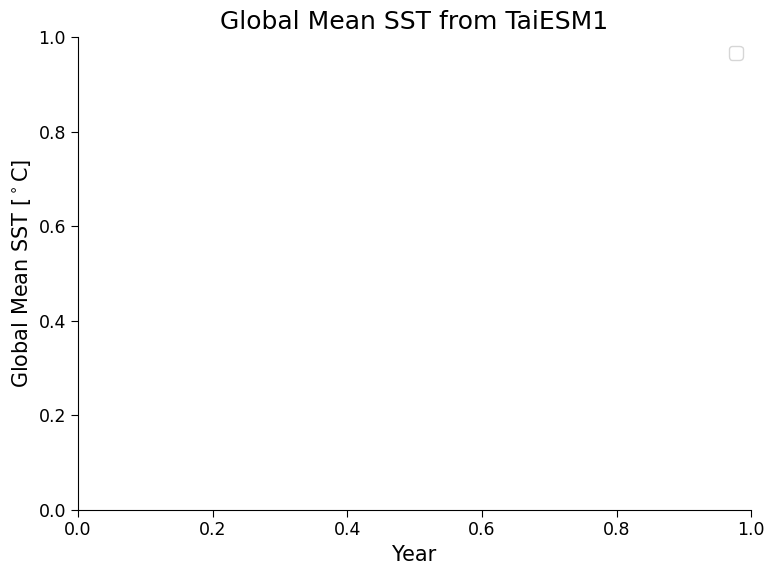

In [9]:
def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# average every dataset in the tree globally
dt_gm = ...
fig, ax = plt.subplots()
for experiment in ["historical", "ssp126", "ssp585"]:
    da = ...
    ...
ax.set_title("Global Mean SST from TaiESM1")
ax.set_ylabel("Global Mean SST [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

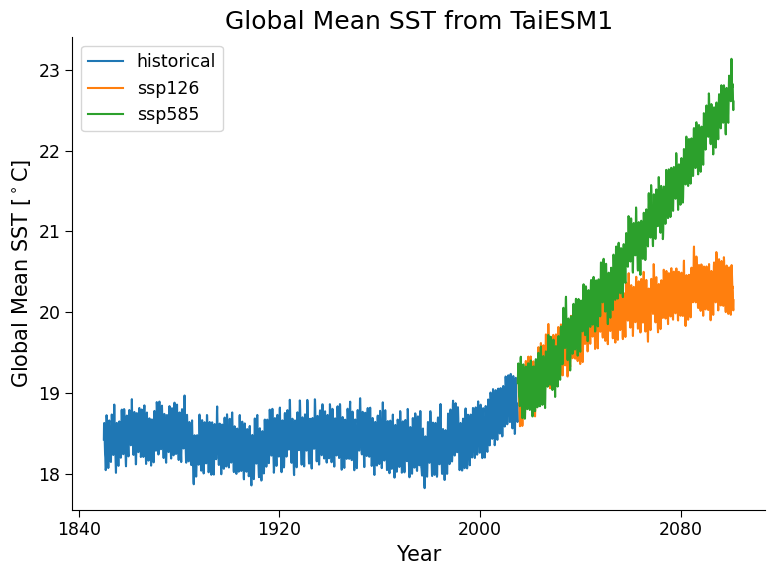

In [10]:
# to_remove solution


def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)
fig, ax = plt.subplots()
for experiment in ["historical", "ssp126", "ssp585"]:
    da = dt_gm["TaiESM1"][experiment].ds.tos
    da.plot(label=experiment, ax=ax)
ax.set_title("Global Mean SST from TaiESM1")
ax.set_ylabel("Global Mean SST [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

### Question 1.1: Climate Connection

1.  Is this plot what you expected? If so, explain what you expected, and why, from the historical experiment, and the SSP1-2.6 and SSP5-8.5 scenarios (see below for a potentially useful figure).

For context, here is [Figure TS.4](https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_TS_Figure_4.png) from the Technical Summary of the [IPCC Sixth Assessment Report](https://www.ipcc.ch/assessment-report/ar6/), which shows how several elements of forcing differ between experiments (including *historical* and *SSP* experiments). In the video above we saw the $CO_2$ panel of this figure:

<img src="https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_TS_Figure_4.png" alt= "Experiment_Forcing" width="1000" height="1000">

Figure TS.4 | The climate change cause–effect chain: The intent of this figure is to illustrate the process chain starting from anthropogenic emissions, to changes in atmospheric concentration, to changes in Earth’s energy balance (‘forcing’), to changes in global climate and ultimately regional climate and climatic impact-drivers. Shown is the core set of five Shared Socio-economic Pathway (SSP) scenarios as well as emissions and concentration ranges for the previous Representative Concentration Pathway (RCP) scenarios in year 2100; carbon dioxide (CO2) emissions (GtCO2yr–1), panel top left; methane (CH4) emissions (middle) and sulphur dioxide (SO2), nitrogen oxide (NOx) emissions (all in Mt yr–1), top right; concentrations of atmospheric CO2(ppm) and CH4 (ppb), second row left and right; effective radiative forcing for both anthropogenic and natural forcings (W m–2), third row; changes in global surface air temperature (°C) relative to 1850–1900, fourth row; maps of projected temperature change (°C) (left) and changes in annual-mean precipitation (%) (right) at a global warming level (GWL) of 2°C relative to 1850–1900 (see also Figure TS.5), bottom row. Carbon cycle and non-CO2 biogeochemical feedbacks will also influence the ultimate response to anthropogenic emissions (arrows on the left). {1.6.1, Cross-Chapter Box 1.4, 4.2.2, 4.3.1, 4.6.1, 4.6.2}

Credit: [IPCC](https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_TS_Figure_4.png)

In [11]:
# to_remove explanation

"""
1. The plots show warming of the ocean surface under SSP1-2.6, and the even greater warming seen under SSP5-8.5. This is expected from the forcing, the emissions under both scenarios lead to an increase in radiative forcing later in the century (which warms the planet), with the highest radiative forcing and warming under the SSP5-8.5 scenario.
""";

# Summary

In tutorial 2, you diagnosed changes at a global scale by calculating global mean timeseries with CMIP6 model mapped data. You then synthesized and compared global mean SST evolution in various CMIP6 experiments, spanning Earth's recent past and several future scenarios. 

We started by loading CMIP6 SST data from three different scenarios: *historical*, *SSP1-2.6* (low-emissions future), and *SSP5-8.5* (high-emissions future). This process expanded our understanding of model outputs. We then focused on calculating global mean SST, by taking into account the spatially-discrete and irregularly-gridded nature of this model's grid cells through a weighted mean. This weighted mean approach yielded the global mean SST, providing a holistic view of the Earth's changing sea surface temperatures under multiple future climate scenarios.


# Resources

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble. 

For examples on how to access and analyze data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html) 

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).